In [1]:
# Dependencies
import requests
import json

import pandas as pd
from pandas_datareader import data
from pandas_datareader import wb

import numpy as np

import time
import datetime as dt
from datetime import datetime

import matplotlib.pyplot as plt

import scipy.stats as st
from scipy.stats import linregress
from scipy.stats import sem

import mplfinance as mpf

# Gather

## Financial Data Collection

Using the pandas DataReader library to request data from Yahoo Finance for the Cryptocurrencies and Stock Exchange information that will be sampled.

**Note:**  
Bitcoin ticker symbol is BTC-USD  
Etheremum ticker symbol is ETH-USD  
Dogecoin ticker symbol is DOGE-USD  
Cardano ticker symbol is ADA-USD  
DOW JONES ticker symbol is ^DJI  
NASDAQ ticker symbol is ^IXIC  

In [2]:
#create a list of cryptocurrencies
crypto_list=["BTC-USD","ETH-USD","DOGE-USD","ADA-USD",]

#define date range
start_d = "2018-06-01"
end_d = "2020-06-30"

#create dataframe
crypto_list_df = data.DataReader(crypto_list, "yahoo", start_d,end_d)

#create a list of Dow Jones and NASDAQ
stock_indexes_list =["^DJI","^IXIC"]

#create dataframe
stock_indexes_list_df = data.DataReader(stock_indexes_list, "yahoo", start_d,end_d)

## Social Media Data Collection

Read in previously called Reddit Comment Data.

In [3]:
bitcoin_comment_times = pd.read_csv('output/comments_bitcoin.csv', index_col = 0)
ethereum_comment_times = pd.read_csv('output/comments_ethereum.csv', index_col= 0)
cardano_comment_times = pd.read_csv('output/comments_cardano.csv', index_col= 0)
dogecoin_comment_times = pd.read_csv('output/comments_dogecoin.csv', index_col= 0)
nasdaq_comment_times = pd.read_csv('output/comments_nasdaq.csv', index_col= 0)
dow_comment_times = pd.read_csv('output/comments_dow.csv', index_col= 0)

C:\Users\12164\anaconda3\envs\PythonData\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Clean

## Financial

### Crypto Highs, Lows, Volumes, and Daily Range

In [4]:
#create cryptocurrency daily high dataframe and save to csv
crypto_high = crypto_list_df.High.rename(columns={"BTC-USD": "Bitcoin High", "ETH-USD": "Ethereum High","DOGE-USD":"Dogecoin High", "ADA-USD":"Cardano High", "Symbols":"" })
crypto_high.to_csv("output/crypto_high.csv")

#multiple indexes making Date a series
crypto_high_no_date_index = crypto_high.reset_index()

#filter out daily low
crypto_low = crypto_list_df.Low.rename(columns={"BTC-USD": "Bitcoin Low", "ETH-USD": "Ethereum Low","DOGE-USD":"Dogecoin Low", "ADA-USD":"Cardano Low" })
crypto_low.to_csv("output/crypto_low.csv")

#multiple indexes making Date a series
crypto_low_no_date_index = crypto_low.reset_index()

#filter out daily volume
crypto_volume = crypto_list_df.Volume.rename(columns={"BTC-USD": "Bitcoin Volume", "ETH-USD": "Ethereum Volume","DOGE-USD":"Dogecoin Volume", "ADA-USD":"Cardano Volume" })
crypto_volume.to_csv("output/crypto_volume.csv")

#multiple indexes making Date a series
crypto_volume_no_date_index = crypto_volume.reset_index()

date_range = crypto_volume_no_date_index["Date"]

In [5]:
crypto_volume = pd.read_csv("output/crypto_volume.csv", index_col= 0)
crypto_high = pd.read_csv("output/crypto_high.csv", index_col= 0)
crypto_low = pd.read_csv("output/crypto_low.csv", index_col= 0)

crypto_change = pd.merge(crypto_high, crypto_low, on = 'Date')
crypto_change['Bitcoin Difference'] = crypto_change['Bitcoin High'] - crypto_change['Bitcoin Low']
crypto_change['Ethereum Difference'] = crypto_change['Ethereum High'] - crypto_change['Ethereum Low']
crypto_change['Dogecoin Difference'] = crypto_change['Dogecoin High'] - crypto_change['Dogecoin Low']
crypto_change['Cardano Difference'] = crypto_change['Cardano High'] - crypto_change['Cardano Low']

### Stock High, Lows, Volumes, and Daily Range

In [6]:
#create stock daily high dataframe and save to csv
stock_indexes_list_high = stock_indexes_list_df.High.round(2).rename(columns={"^DJI": "Dow Jones High", "^IXIC":"NASDAQ High"})
stock_indexes_list_high.to_csv("output/stock_indexes_high.csv")

#create stock daily low dataframe and save to csv
stock_indexes_list_low = stock_indexes_list_df.Low.round(2).rename(columns={"^DJI": "Dow Jones Low", "^IXIC":"NASDAQ Low"})
stock_indexes_list_low.to_csv("output/stock_indexes_low.csv")

#create stock daily volume dataframe and save to csv
stock_indexes_list_volume = stock_indexes_list_df.Volume.rename(columns={"^DJI": "Dow Jones Volume", "^IXIC":"NASDAQ Volume"})
stock_indexes_list_volume.to_csv("output/stock_indexes_volume.csv")


In [7]:
stock_indexes_list_volume = pd.read_csv("output/stock_indexes_volume.csv", index_col= 0)
stock_indexes_high = pd.read_csv("output/stock_indexes_high.csv", index_col= 0)
stock_indexes_low = pd.read_csv("output/stock_indexes_low.csv", index_col= 0)

stock_change = pd.merge(stock_indexes_high, stock_indexes_low, on = 'Date')

stock_change['Dow Jones Difference'] = stock_change['Dow Jones High'] - stock_change['Dow Jones Low']
stock_change['NASDAQ Difference'] = stock_change['NASDAQ High'] - stock_change['NASDAQ Low']

## Social

### Join separate calls into one dataframe, changing the Timestamp into a readable data

In [8]:
bitcoin_comment_times['Exchange']= 'Bitcoin'
ethereum_comment_times['Exchange']= 'Ethereum'
cardano_comment_times['Exchange']= 'Cardano'
dogecoin_comment_times['Exchange']= 'Dogecoin'
nasdaq_comment_times['Exchange']= 'NASDAQ'
dow_comment_times['Exchange']= 'Dow Jones'

reddit_comments = pd.concat([bitcoin_comment_times, ethereum_comment_times, cardano_comment_times, dogecoin_comment_times, nasdaq_comment_times, dow_comment_times], ignore_index= True, keys = ('Bitcoin', 'Ethereum', 'Cardano', 'Dogecoin', 'NASDAQ', 'Dow Jones'))

reddit_comments['DateTime']= [datetime.fromtimestamp(i) for i in reddit_comments['Timestamp']]

reddit_comments['Date'] = reddit_comments['DateTime'].dt.date

reddit_comments_clean = reddit_comments[['Date', 'SubReddit', 'Exchange']]

reddit_comment_count = pd.DataFrame(reddit_comments_clean.groupby(['Exchange', 'Date']).count()).reset_index().rename(columns= {'SubReddit': 'Comment Count'})

In [9]:
bit_volume = crypto_volume[['Bitcoin Volume']]
bit_volume.reset_index(inplace=True)

bit_difference = crypto_change[['Bitcoin Difference']]
bit_difference.reset_index(inplace=True)

bit_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='Bitcoin', ['Date', 'Comment Count']]
bit_comments.reset_index()
bit_comments['Date'] = [i.strftime("%Y-%m-%d") for i in bit_comments['Date']]

bit_vol_merged_df = pd.merge(bit_comments, bit_volume)
bit_merged_df = pd.merge(bit_vol_merged_df, bit_difference)

bit_count_merged = bit_merged_df['Comment Count']
bit_volume_merged = bit_merged_df['Bitcoin Volume']
bit_delta_merged = bit_merged_df['Bitcoin Difference']

In [10]:
ether_volume = crypto_volume[['Ethereum Volume']]
ether_volume.reset_index(inplace=True)

ether_difference = crypto_change[['Ethereum Difference']]
ether_difference.reset_index(inplace=True)

ether_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='Ethereum', ['Date', 'Comment Count']]
ether_comments.reset_index()
ether_comments['Date'] = [i.strftime("%Y-%m-%d") for i in ether_comments['Date']]

ether_vol_merged_df = pd.merge(ether_comments, ether_volume)
ether_merged_df = pd.merge(ether_vol_merged_df, ether_difference)

ether_count_merged = ether_merged_df['Comment Count']
ether_volume_merged = ether_merged_df['Ethereum Volume']
ether_delta_merged = ether_merged_df['Ethereum Difference']

In [11]:
card_volume = crypto_volume[['Cardano Volume']]
card_volume.reset_index(inplace=True)

card_difference = crypto_change[['Cardano Difference']]
card_difference.reset_index(inplace=True)

card_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='Cardano', ['Date', 'Comment Count']]
card_comments.reset_index()
card_comments['Date'] = [i.strftime("%Y-%m-%d") for i in card_comments['Date']]

card_vol_merged_df = pd.merge(card_comments, card_volume)
card_merged_df = pd.merge(card_vol_merged_df, card_difference)

card_count_merged = card_merged_df['Comment Count']
card_volume_merged = card_merged_df['Cardano Volume']
card_delta_merged = card_merged_df['Cardano Difference']

In [12]:
doge_volume = crypto_volume[['Dogecoin Volume']]
doge_volume.reset_index(inplace=True)

doge_difference = crypto_change[['Dogecoin Difference']]
doge_difference.reset_index(inplace=True)

doge_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='Dogecoin', ['Date', 'Comment Count']]
doge_comments.reset_index()
doge_comments['Date'] = [i.strftime("%Y-%m-%d") for i in doge_comments['Date']]

doge_vol_merged_df = pd.merge(doge_comments, doge_volume)
doge_merged_df = pd.merge(doge_vol_merged_df, doge_difference)

doge_count_merged = doge_merged_df['Comment Count']
doge_volume_merged = doge_merged_df['Dogecoin Volume']
doge_delta_merged = doge_merged_df['Dogecoin Difference']

In [13]:
nasdaq_volume = stock_indexes_list_volume[['NASDAQ Volume']]
nasdaq_volume.reset_index(inplace=True)

nasdaq_difference = stock_change[['NASDAQ Difference']]
nasdaq_difference.reset_index(inplace=True)

nasdaq_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='NASDAQ', ['Date', 'Comment Count']]
nasdaq_comments.reset_index()
nasdaq_comments['Date'] = [i.strftime("%Y-%m-%d") for i in nasdaq_comments['Date']]


nasdaq_vol_merged_df = pd.merge(nasdaq_comments, nasdaq_volume)
nasdaq_merged_df = pd.merge(nasdaq_vol_merged_df, nasdaq_difference)

nasdaq_count_merged = nasdaq_merged_df['Comment Count']
nasdaq_volume_merged = nasdaq_merged_df['NASDAQ Volume']
nasdaq_delta_merged = nasdaq_merged_df['NASDAQ Difference']

In [14]:
dow_volume = stock_indexes_list_volume[['Dow Jones Volume']]
dow_volume.reset_index(inplace=True)

dow_difference = stock_change[['Dow Jones Difference']]
dow_difference.reset_index(inplace=True)

dow_comments = reddit_comment_count.loc[reddit_comment_count['Exchange']=='Dow Jones', ['Date', 'Comment Count']]
dow_comments.reset_index()
dow_comments['Date'] = [i.strftime("%Y-%m-%d") for i in dow_comments['Date']]


dow_vol_merged_df = pd.merge(dow_comments, dow_volume)
dow_merged_df = pd.merge(dow_vol_merged_df, dow_difference)

dow_count_merged = dow_merged_df['Comment Count']
dow_volume_merged = dow_merged_df['Dow Jones Volume']
dow_delta_merged = dow_merged_df['Dow Jones Difference']

# Plot

### Cryptocurrency Daily Volume Over Time

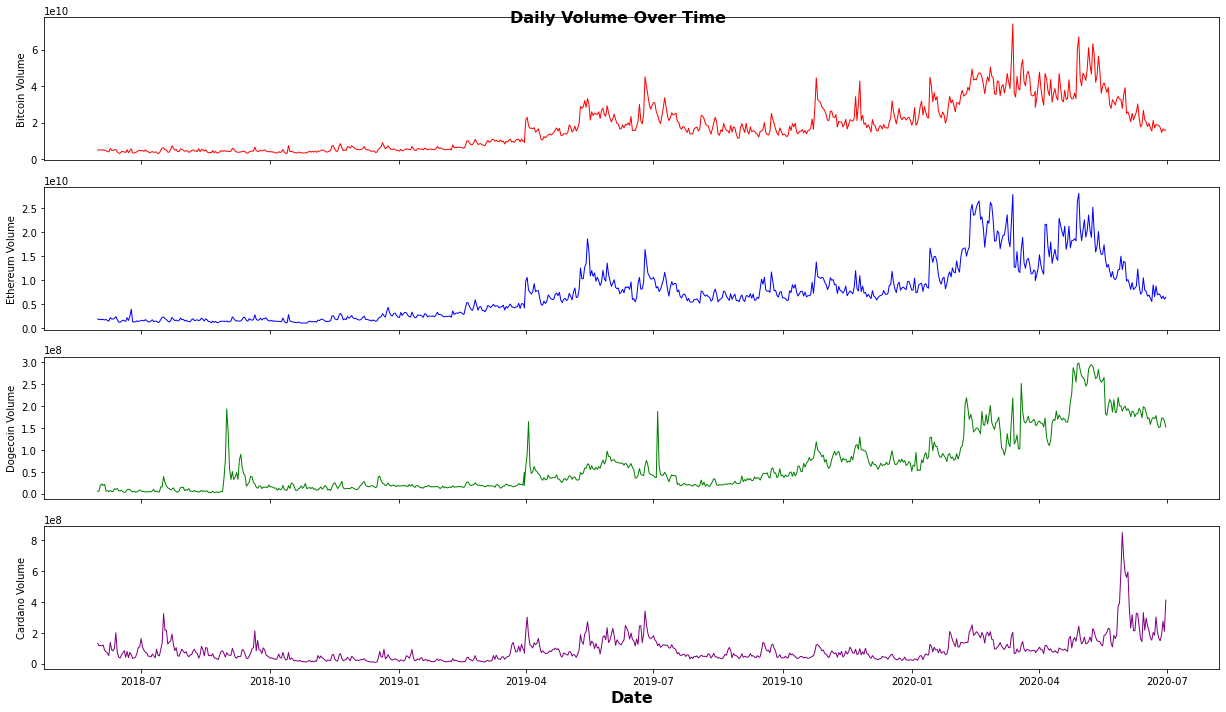

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True,figsize=(17,10))
fig.suptitle("Daily Volume Over Time", fontsize=16, fontweight="bold")

ax1.plot(date_range, crypto_volume["Bitcoin Volume"], linewidth=1, color ="red")
ax1.set_ylabel("Bitcoin Volume")

ax2.plot(date_range, crypto_volume["Ethereum Volume"], linewidth=1, color ="blue")
ax2.set_ylabel("Ethereum Volume")

ax3.plot(date_range, crypto_volume["Dogecoin Volume"], linewidth=1,color ="green")
ax3.set_ylabel("Dogecoin Volume")

ax4.plot(date_range, crypto_volume["Cardano Volume"], linewidth=1, color ="purple")
ax4.set_ylabel("Cardano Volume")
ax4.set_xlabel("Date", fontsize=16, fontweight="bold")

#save plot
plt.savefig("output/crypto_volume.png")

plt.tight_layout()
plt.show()

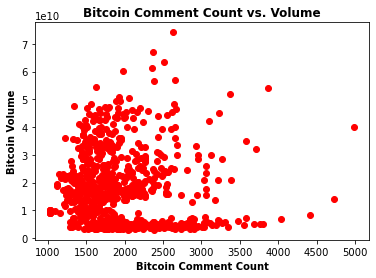

In [16]:
plt.scatter(bit_count_merged, bit_volume_merged,color ="red")
plt.xlabel("Bitcoin Comment Count",fontweight="bold")
plt.ylabel("Bitcoin Volume",fontweight="bold")
plt.title("Bitcoin Comment Count vs. Volume",fontweight="bold")

#save plot
plt.savefig("output/bitcoin_scatter_volume.png")

plt.show()

In [17]:
plt.scatter(bit_count_merged, bit_delta_merged,color ="red")
plt.xlabel("Bitcoin Comment Count",fontweight="bold")
plt.ylabel("Bitcoin Change in Price",fontweight="bold")
plt.title("Bitcoin Comment Count vs. Change in Price",fontweight="bold")

#save plot
plt.savefig("output/bitcoin_scatter.png")

plt.show()

NameError: name 'bit_delta' is not defined

The correlation between Ethereum Reddit Comments and the Ethereum Volume in June 1, 2018 to June 30, 2020 is -0.4155885233514123


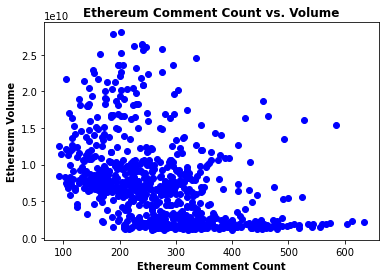

In [15]:
correlation = st.pearsonr(ether_comments_merged, ether_volume_merged)

print(f"The correlation between Ethereum Reddit Comments and the Ethereum Volume in June 1, 2018 to June 30, 2020 is {correlation[0]}")

plt.scatter(ether_comments_merged, ether_volume_merged, color ="blue")
plt.xlabel("Ethereum Comment Count",fontweight="bold")
plt.ylabel("Ethereum Volume",fontweight="bold")
plt.title("Ethereum Comment Count vs. Volume",fontweight="bold")

#save plot
plt.savefig("output/ethereum_scatter_volume.png")

plt.show()

The correlation between Bitcoin Reddit Comments and the Bitcoin change in Price in June 1, 2018 to June 30, 2020 is 0.3875271313881695


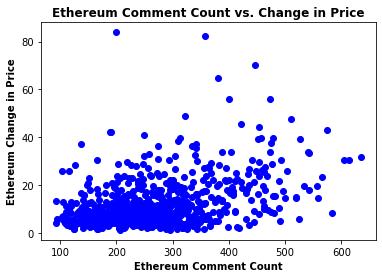

In [16]:
ether_difference = crypto_change[['Ethereum Difference']]
ether_difference.reset_index(inplace=True)

ether_diff_merged = pd.merge(ether_comments, ether_difference)
ether_com = ether_diff_merged['SubReddit']
ether_diff = ether_diff_merged['Ethereum Difference']

correlation = st.pearsonr(ether_com, ether_diff)

print(f"The correlation between Bitcoin Reddit Comments and the Bitcoin change in Price in June 1, 2018 to June 30, 2020 is {correlation[0]}")

plt.scatter(ether_com, ether_diff, color ="blue")
plt.xlabel("Ethereum Comment Count",fontweight="bold")
plt.ylabel("Ethereum Change in Price",fontweight="bold")
plt.title("Ethereum Comment Count vs. Change in Price",fontweight="bold")

#save plot
plt.savefig("output/ethereum_scatter.png")

plt.show()

The correlation between Cardano Reddit Comments and the Cardano Volume in June 1, 2018 to June 30, 2020 is 0.2845740181977755


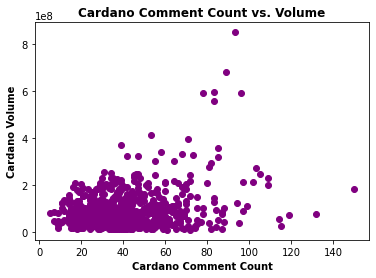

In [17]:
card_comments = df.loc[df['Exchange']=='Cardano', ['Date', 'SubReddit']]
card_comments.reset_index()
card_comments['Date'] = [i.strftime("%Y-%m-%d") for i in card_comments['Date']]
card_volume = crypto_volume[["Cardano Volume"]]
card_volume.reset_index(inplace=True)
card_merged_df = pd.merge(card_comments, card_volume)
card_comments_merged = card_merged_df['SubReddit']
card_volume_merged = card_merged_df['Cardano Volume']
correlation = st.pearsonr(card_comments_merged, card_volume_merged)

print(f"The correlation between Cardano Reddit Comments and the Cardano Volume in June 1, 2018 to June 30, 2020 is {correlation[0]}")
plt.scatter(card_comments_merged, card_volume_merged, color ="purple")
plt.xlabel("Cardano Comment Count",fontweight="bold")
plt.ylabel("Cardano Volume",fontweight="bold")
plt.title("Cardano Comment Count vs. Volume",fontweight="bold")

#save plot
plt.savefig("output/cardano_scatter_volume.png")

plt.show()

The correlation between Cardano Reddit Comments and the Cardano change in Price in June 1, 2018 to June 30, 2020 is 0.2580703448408521


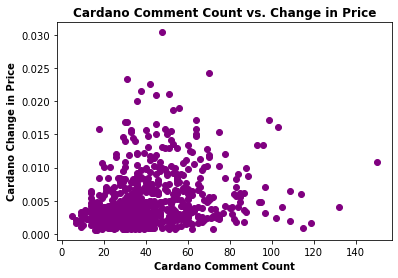

In [18]:
card_difference = crypto_change[['Cardano Difference']]
card_difference.reset_index(inplace=True)

card_diff_merged = pd.merge(card_comments, card_difference)
card_com = card_diff_merged['SubReddit']
card_diff = card_diff_merged['Cardano Difference']

correlation = st.pearsonr(card_com, card_diff)

print(f"The correlation between Cardano Reddit Comments and the Cardano change in Price in June 1, 2018 to June 30, 2020 is {correlation[0]}")

plt.scatter(card_com, card_diff,color ="purple")
plt.xlabel("Cardano Comment Count",fontweight="bold")
plt.ylabel("Cardano Change in Price",fontweight="bold")
plt.title("Cardano Comment Count vs. Change in Price",fontweight="bold")

#save plot
plt.savefig("output/cardano_scatter.png")

plt.show()

The correlation between Dogecoin Reddit Comments and the Dogecoin Volume in June 1, 2018 to June 30, 2020 is -0.1598712877065133


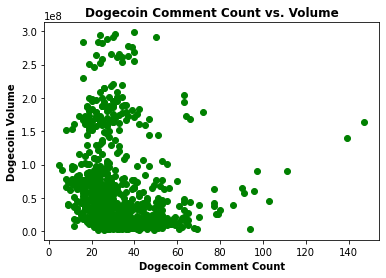

In [19]:
doge_comments = df.loc[df['Exchange']=='Dogecoin', ['Date', 'SubReddit']]
doge_comments.reset_index()
doge_comments['Date'] = [i.strftime("%Y-%m-%d") for i in doge_comments['Date']]
doge_volume = crypto_volume[["Dogecoin Volume"]]
doge_volume.reset_index(inplace=True)
doge_merged_df = pd.merge(doge_comments, doge_volume)
doge_comments_merged = doge_merged_df['SubReddit']
doge_volume_merged = doge_merged_df['Dogecoin Volume']
correlation = st.pearsonr(doge_comments_merged, doge_volume_merged)

print(f"The correlation between Dogecoin Reddit Comments and the Dogecoin Volume in June 1, 2018 to June 30, 2020 is {correlation[0]}")
plt.scatter(doge_comments_merged, doge_volume_merged,color ="green")
plt.xlabel("Dogecoin Comment Count",fontweight="bold")
plt.ylabel("Dogecoin Volume",fontweight="bold")
plt.title("Dogecoin Comment Count vs. Volume",fontweight="bold")

#save plot
plt.savefig("output/dogecoin_scatter_volume.png")

plt.show()

The correlation between Dogecoin Reddit Comments and the Dogecoin change in Price in June 1, 2018 to June 30, 2020 is 0.4618681910462514


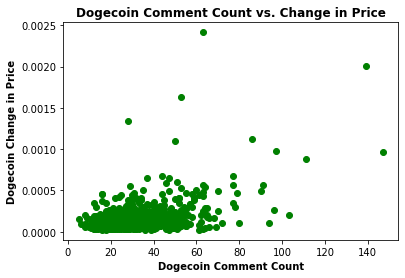

In [20]:
doge_difference = crypto_change[['Dogecoin Difference']]
doge_difference.reset_index(inplace=True)

doge_diff_merged = pd.merge(doge_comments, doge_difference)
doge_com = doge_diff_merged['SubReddit']
doge_diff = doge_diff_merged['Dogecoin Difference']

correlation = st.pearsonr(doge_com, doge_diff)

print(f"The correlation between Dogecoin Reddit Comments and the Dogecoin change in Price in June 1, 2018 to June 30, 2020 is {correlation[0]}")

plt.scatter(doge_com, doge_diff,color ="green")
plt.xlabel("Dogecoin Comment Count",fontweight="bold")
plt.ylabel("Dogecoin Change in Price",fontweight="bold")
plt.title("Dogecoin Comment Count vs. Change in Price",fontweight="bold")

#save plot
plt.savefig("output/dogecoin_scatter.png")

plt.show()

In [21]:
stock_indexes_list_volume = pd.read_csv("output/stock_indexes_volume.csv", index_col= 0)
stock_indexes_high = pd.read_csv("output/stock_indexes_high.csv", index_col= 0)
stock_indexes_low = pd.read_csv("output/stock_indexes_low.csv", index_col= 0)

stock_change = pd.merge(stock_indexes_high, stock_indexes_low, on = 'Date')

stock_change['Dow Jones Difference'] = stock_change['Dow Jones High'] - stock_change['Dow Jones Low']
stock_change['NASDAQ Difference'] = stock_change['NASDAQ High'] - stock_change['NASDAQ Low']

stock_change

Dow Jones High  NASDAQ High  Dow Jones Low  NASDAQ Low  \
Date                                                                 
2018-06-01        24673.60      7557.38       24542.09     7487.23   
2018-06-04        24859.37      7607.17       24722.14     7561.20   
2018-06-05        24838.78      7644.48       24710.82     7602.38   
2018-06-06        25146.46      7691.65       24854.14     7622.31   
2018-06-07        25326.09      7697.41       25164.48     7597.66   
...                    ...          ...            ...         ...   
2020-06-24        25992.96     10137.50       25296.73     9842.22   
2020-06-25        25769.61     10023.28       25209.79     9810.47   
2020-06-26        25641.69     10000.67       24971.03     9749.07   
2020-06-29        25601.15      9877.34       25096.16     9663.61   
2020-06-30        25905.38     10085.59       25475.14     9863.67   

            Dow Jones Difference  NASDAQ Difference  
Date                                                 
2018-06-01                131.51              70.15  
2018-06-04                137.23              45.97  
2018-06-05                127.96              42.10  
2018-06-06                292.32              69.34  
2018-06-07                161.61              99.75  
...                          ...                ...  
2020-06-24                696.23             295.28  
2020-06-25                559.82             212.81  
2020-06-26                670.66             251.60  
2020-06-29                504.99             213.73  
2020-06-30                430.24             221.92  

[524 rows x 6 columns]

The correlation between NASDAQ Reddit Comments and the NASDAQ Volume in June 1, 2018 to June 30, 2020 is 0.7394253806748537


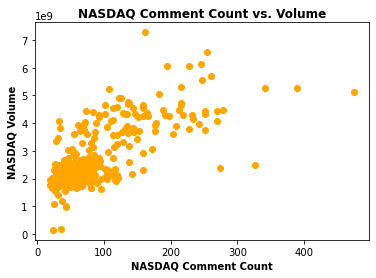

In [22]:
nasdaq_comments = df.loc[df['Exchange']=='NASDAQ', ['Date', 'SubReddit']]
nasdaq_comments.reset_index()
nasdaq_comments['Date'] = [i.strftime("%Y-%m-%d") for i in nasdaq_comments['Date']]
nasdaq_volume = stock_indexes_list_volume[['NASDAQ Volume']]
nasdaq_volume.reset_index(inplace=True)
nasdaq_merged_df = pd.merge(nasdaq_comments, nasdaq_volume)
nasdaq_comments_merged = nasdaq_merged_df['SubReddit']
nasdaq_volume_merged = nasdaq_merged_df['NASDAQ Volume']
correlation = st.pearsonr(nasdaq_comments_merged, nasdaq_volume_merged)

print(f"The correlation between NASDAQ Reddit Comments and the NASDAQ Volume in June 1, 2018 to June 30, 2020 is {correlation[0]}")
plt.scatter(nasdaq_comments_merged, nasdaq_volume_merged,color ="orange")
plt.xlabel("NASDAQ Comment Count",fontweight="bold")
plt.ylabel("NASDAQ Volume",fontweight="bold")
plt.title("NASDAQ Comment Count vs. Volume",fontweight="bold")

#save plot
plt.savefig("output/nasdaq_scatter_volume.png")

plt.show()

The correlation between NASDAQ Reddit Comments and the NASDAQ change in Price in June 1, 2018 to June 30, 2020 is 0.4263275477851225


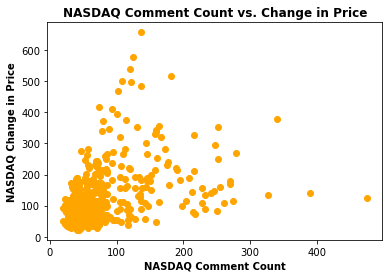

In [23]:
nasdaq_difference = stock_change[['NASDAQ Difference']]
nasdaq_difference.reset_index(inplace=True)

nasdaq_diff_merged = pd.merge(nasdaq_comments, nasdaq_difference)
nasdaq_com = nasdaq_diff_merged['SubReddit']
nasdaq_diff = nasdaq_diff_merged['NASDAQ Difference']

correlation = st.pearsonr(nasdaq_com, nasdaq_diff)

print(f"The correlation between NASDAQ Reddit Comments and the NASDAQ change in Price in June 1, 2018 to June 30, 2020 is {correlation[0]}")

plt.scatter(nasdaq_com, nasdaq_diff,color ="orange")
plt.xlabel("NASDAQ Comment Count",fontweight="bold")
plt.ylabel("NASDAQ Change in Price",fontweight="bold")
plt.title("NASDAQ Comment Count vs. Change in Price",fontweight="bold")

#save plot
plt.savefig("output/nasdaq_scatter.png")

plt.show()

The correlation between Dow Comments and the Dow Jones in June 1, 2018 to June 30, 2020 is 0.7775113642547149


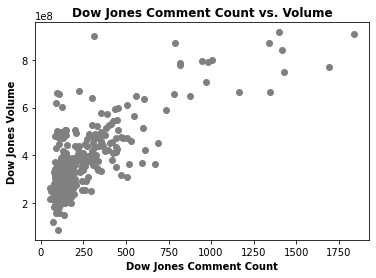

In [24]:
dow_volume = stock_indexes_list_volume[['Dow Jones Volume']]
dow_volume.reset_index(inplace=True)
dow_comments = df.loc[df['Exchange']=='Dow Jones', ['Date', 'SubReddit']]
dow_comments.reset_index()
dow_comments['Date'] = [i.strftime("%Y-%m-%d") for i in dow_comments['Date']]
dow_merged_df = pd.merge(dow_comments, dow_volume)
dow_comments_merged = dow_merged_df['SubReddit']
dow_volume_merged = dow_merged_df['Dow Jones Volume']
correlation = st.pearsonr(dow_comments_merged, dow_volume_merged)

print(f"The correlation between Dow Comments and the Dow Jones in June 1, 2018 to June 30, 2020 is {correlation[0]}")
plt.scatter(dow_comments_merged, dow_volume_merged,color ="gray")
plt.xlabel("Dow Jones Comment Count",fontweight="bold")
plt.ylabel("Dow Jones Volume",fontweight="bold")
plt.title("Dow Jones Comment Count vs. Volume",fontweight="bold")

#save plot
plt.savefig("output/dow_scatter_volume.png")

plt.show()

The correlation between Dow Jones Reddit Comments and the Dow Jones change in Price in June 1, 2018 to June 30, 2020 is 0.8208300478702695


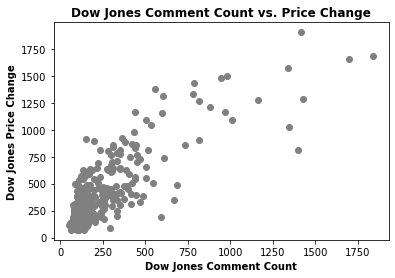

In [25]:
dow_difference = stock_change[['Dow Jones Difference']]
dow_difference.reset_index(inplace=True)

dow_diff_merged = pd.merge(dow_comments, dow_difference)
dow_com = dow_diff_merged['SubReddit']
dow_diff = dow_diff_merged['Dow Jones Difference']

correlation = st.pearsonr(dow_com, dow_diff)

print(f"The correlation between Dow Jones Reddit Comments and the Dow Jones change in Price in June 1, 2018 to June 30, 2020 is {correlation[0]}")

plt.scatter(dow_com, dow_diff, color ="gray")
plt.xlabel("Dow Jones Comment Count",fontweight="bold")
plt.ylabel("Dow Jones Price Change",fontweight="bold")
plt.title("Dow Jones Comment Count vs. Price Change",fontweight="bold")

#save plot
plt.savefig("output/dow_scatter.png")

plt.show()

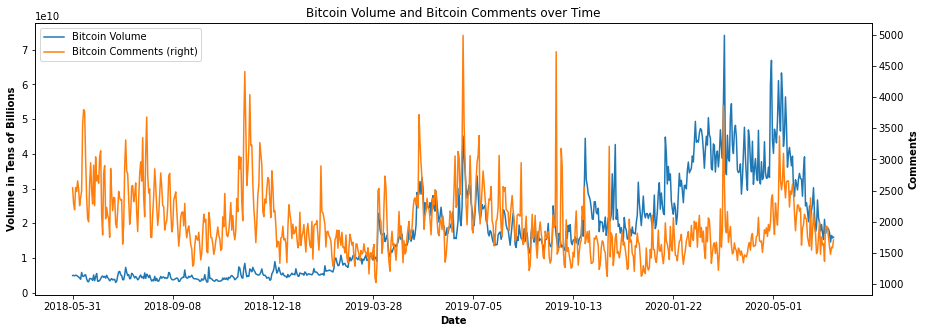

In [26]:
bitcoin_comment_vs_volume = crypto_volume[['Bitcoin Volume']].plot()

bit_comments.plot(ax = bitcoin_comment_vs_volume, secondary_y = True,figsize=(15,5),title = "Bitcoin Volume and Bitcoin Comments over Time").set_ylabel("Comments",fontweight="bold")

bitcoin_comment_vs_volume.set_xlabel("Date",fontweight="bold")
bitcoin_comment_vs_volume.set_ylabel("Volume in Tens of Billions",fontweight="bold")


#save plot
plt.savefig("output/bitcoin_volume_and_comments.png")

plt.show()

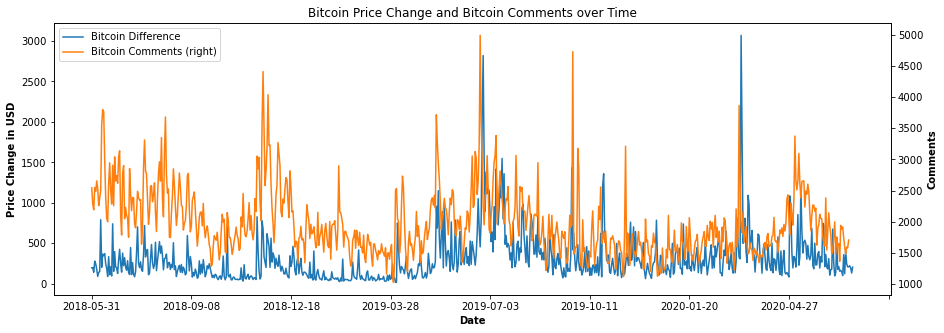

In [27]:
bitcoin_comment_vs_price = crypto_change[['Bitcoin Difference']].plot()

bit_comments.plot(ax = bitcoin_comment_vs_price, secondary_y = True,figsize=(15,5),title = "Bitcoin Price Change and Bitcoin Comments over Time").set_ylabel("Comments",fontweight="bold")

bitcoin_comment_vs_price.set_xlabel("Date",fontweight="bold")
bitcoin_comment_vs_price.set_ylabel("Price Change in USD",fontweight="bold")


#save plot
plt.savefig("output/bitcoin_price_change_and_comments.png")

plt.show()

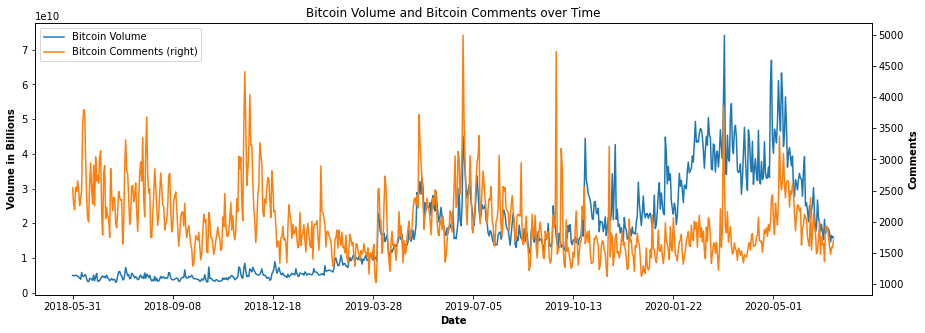

In [28]:
bitcoin_comment_vs_volume = crypto_volume[['Bitcoin Volume']].plot()

bit_comments.plot(ax = bitcoin_comment_vs_volume, secondary_y = True,figsize=(15,5),title = "Bitcoin Volume and Bitcoin Comments over Time").set_ylabel("Comments",fontweight="bold")

bitcoin_comment_vs_volume.set_xlabel("Date",fontweight="bold")
bitcoin_comment_vs_volume.set_ylabel("Volume in Billions",fontweight="bold")


#save plot
plt.savefig("output/bitcoin_volume_and_comments.png")

plt.show()

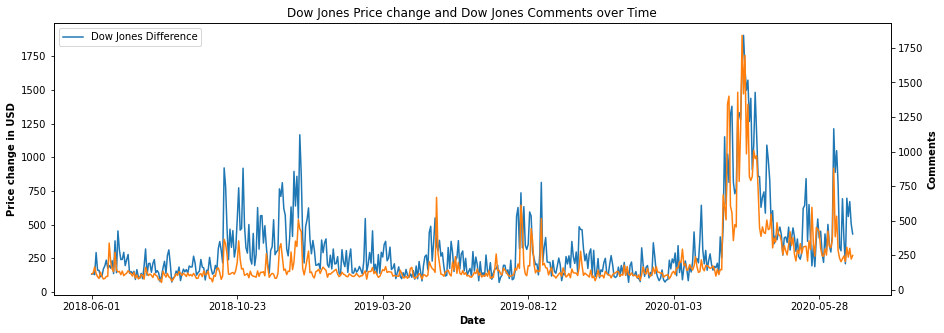

In [29]:
dow_comment_vs_price_change = stock_change[['Dow Jones Difference']].plot()

dow_diff_merged['SubReddit'].plot(ax = dow_comment_vs_price_change, secondary_y = True,figsize=(15,5),title = "Dow Jones Price change and Dow Jones Comments over Time").set_ylabel("Comments",fontweight="bold")

dow_comment_vs_price_change.set_xlabel("Date",fontweight="bold")
dow_comment_vs_price_change.set_ylabel("Price change in USD",fontweight="bold")


#save plot
plt.savefig("output/dow_price_change_and_comments.png")

plt.show()

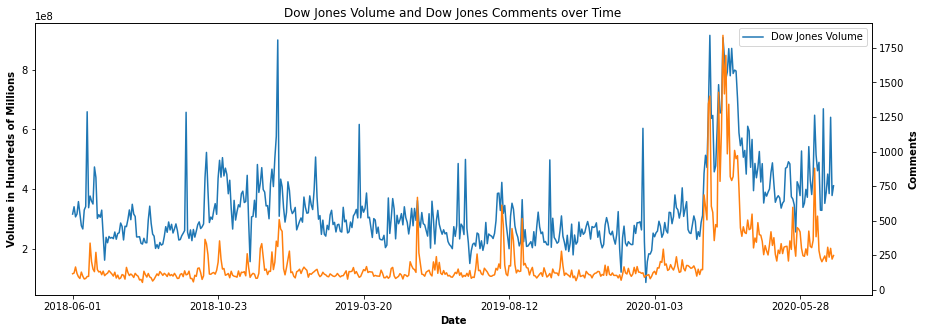

In [30]:
dow_comment_vs_volume = stock_indexes_list_volume[['Dow Jones Volume']].plot()

dow_diff_merged['SubReddit'].plot(ax = dow_comment_vs_volume, secondary_y = True,figsize=(15,5),title = "Dow Jones Volume and Dow Jones Comments over Time").set_ylabel("Comments",fontweight="bold")

dow_comment_vs_volume.set_xlabel("Date",fontweight="bold")
dow_comment_vs_volume.set_ylabel("Volume in Hundreds of Millions",fontweight="bold")


#save plot
plt.savefig("output/dow_volume_and_comments.png")

plt.show()

# Analyze

In [28]:
bit_volume_correlation = st.pearsonr(bit_count_merged, bit_volume_merged)
bit_delta_correlation = st.pearsonr(bit_count_merged, bit_delta_merged)

print(f"From the time period of June 1, 2018 to June 30, 2020:\nThe correlation between Bitcoin Reddit Comments and Daily Volume is     {bit_volume_correlation[0]}. \nThe correlation between Bitcoin Reddit Comments and Daily Price Range is {bit_delta_correlation[0]}.")

From the time period of June 1, 2018 to June 30, 2020:
The correlation between Bitcoin Reddit Comments and Daily Volume is     -0.07526784765363906. 
The correlation between Bitcoin Reddit Comments and Daily Price Range is 0.3839140636010183.


In [ ]:
ether_volume_correlation = st.pearsonr(ether_count_merged, ether_volume_merged)
ether_delta_correlation = st.pearsonr(ether_count_merged, ether_delta_merged)

print(f"From the time period of June 1, 2018 to June 30, 2020:\nThe correlation between Ethereum Reddit Comments and Daily Volume is     {ether_volume_correlation[0]}. \nThe correlation between Ethereum Reddit Comments and Daily Price Range is {ether_delta_correlation[0]}.")

In [ ]:
card_volume_correlation = st.pearsonr(card_count_merged, card_volume_merged)
card_delta_correlation = st.pearsonr(card_count_merged, card_delta_merged)

print(f"From the time period of June 1, 2018 to June 30, 2020:\nThe correlation between Cardano Reddit Comments and Daily Volume is     {card_volume_correlation[0]}. \nThe correlation between Cardano Reddit Comments and Daily Price Range is {card_delta_correlation[0]}.")

In [ ]:
doge_volume_correlation = st.pearsonr(doge_count_merged, doge_volume_merged)
doge_delta_correlation = st.pearsonr(doge_count_merged, doge_delta_merged)

print(f"From the time period of June 1, 2018 to June 30, 2020:\nThe correlation between Dogecoin Reddit Comments and Daily Volume is     {doge_volume_correlation[0]}. \nThe correlation between Dogecoin Reddit Comments and Daily Price Range is {doge_delta_correlation[0]}.")

In [ ]:
nasdaq_volume_correlation = st.pearsonr(nasdaq_count_merged, nasdaq_volume_merged)
nasdaq_delta_correlation = st.pearsonr(nasdaq_count_merged, nasdaq_delta_merged)

print(f"From the time period of June 1, 2018 to June 30, 2020:\nThe correlation between NASDAQ Reddit Comments and Daily Volume is     {nasdaq_volume_correlation[0]}. \nThe correlation between NASDAQ Reddit Comments and Daily Price Range is {nasdaq_delta_correlation[0]}.")

In [ ]:
dow_volume_correlation = st.pearsonr(dow_count_merged, dow_volume_merged)
dow_delta_correlation = st.pearsonr(dow_count_merged, dow_delta_merged)

print(f"From the time period of June 1, 2018 to June 30, 2020:\nThe correlation between Dow Jones Reddit Comments and Daily Volume is     {dow_volume_correlation[0]}. \nThe correlation between Dow Jones Reddit Comments and Daily Price Range is {dow_delta_correlation[0]}.")